### PS6
### Jiang Wang

Issue Description and Summary: 
Some of the instructions in PS6 provide R but not Python codes. Considering that there are different arguments and ways of computing in different environments, it is not easy to align with the instructions. Therefore, I would like to prepose the following solutions:

for question a), I intentionally to keep the tree small (with small max_depth). It is better for me to interpret the results and also better for graders to grade it.

for question b), I apply greedy algorithm and run through all likely values of max_depth and min_samples_leaf and pick the one with the lowest the MSE.

for question c) and d), I have some issues with the variable importance part. I guess it is about sorting and then mapping the indices to labels. The source thread can be found here: https://github.com/UC-MACSS/persp-model_W18/issues/228.
Since I have not discussed with the TA yet, I provide both solutions (in the original thread and my fixes) and examine their results. I believe the issue can be solved during the coming week.

In [1]:
#Import packages
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor #used in part c and d
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
import scipy.optimize as opt
%matplotlib inline

C:\Users\jiangwang-admin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read-in data
biden = pd.read_csv('biden.csv',sep=',')
biden.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


#### (a) Split the data into a training set (70%) and a test set (30%). Be sure to set your seed prior to this part of your code to guarantee reproducibility of results. Use recursive binary splitting to fit a decision tree to the training data, with biden as the response variable and the other variables as predictors. Plot the tree and interpret the results. What is the test MSE?

In [3]:
variables = ['female','age','educ','dem','rep']
X = biden[variables].values
y = biden['biden'].values
#Set seed
np.random.seed(seed=1)
#Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3,
                                                    random_state=25)

In [4]:
biden_tree = DecisionTreeRegressor(max_depth=2, min_samples_leaf=3)
biden_tree.fit(X_train, y_train)
y_pred = biden_tree.predict(X_test)
MSE_a = mean_squared_error(y_test, y_pred)
print('The test MSE is',MSE_a)

The test MSE is 400.065398184


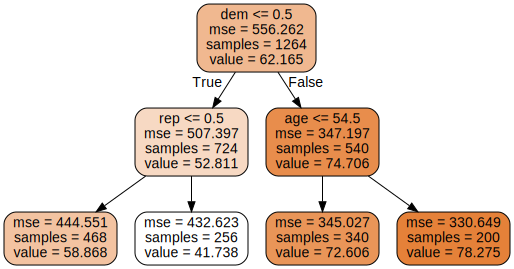

In [5]:
biden_tree_viz = export_graphviz(biden_tree, out_file=None, rounded=True, 
                                 filled=True, feature_names=variables)
graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

Python does not have good default setting so that the given tree will be incredibly large. As you can see, I intentionally to keep the tree small, good for both visualization and interpretation. 

The sample average is 62.165. At the first step, the data is splitted by 'dem'. People who incline to the democrats (dem>0.5) tend to have higher biden scores (average = 74.7) compared those who do not incline to the domocrats (average = 52.8).

At the second step, for those who incline to democrats, the data is splitted by 'age'. People who are aged over 54.5 tend to have higher biden scores (average = 78.3) compared those who aged less than or equal to 54.5 (average = 72.6). For those who are not inclined to the democrats, the data is splitted by 'rep'. The score is higher for those who are not inclined to the republicans (average = 58.9) compared with the democrats (average = 41.7).

#### (b) Leave the control options for tree() at their default values. Now fit another tree to the training data with the following control options: tree(control = tree.control(nobs = # number of rows in the training set, mindev = 0)) Use cross-validation to determine the optimal level of tree complexity, plot the optimal tree, and interpret the results. Does pruning the tree improve the test MSE?

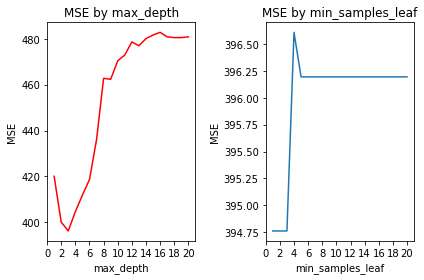

In [6]:
max_samples = 20
MSE_vec = np.zeros(max_samples)
MSE_vec2 = np.zeros(max_samples)
counter = 0
#check the suitable max of depth for minimum MSE
for d in range(max_samples):
    biden_tree_test = DecisionTreeRegressor(max_depth=d+1, min_samples_leaf=5)
    biden_tree_test.fit(X_train, y_train)
    y_pred_test = biden_tree_test.predict(X_test)
    MSE_test = mean_squared_error(y_test, y_pred_test)
    #print('max_depth = {}, MSE = {}'.format(d+1, MSE_test))
    MSE_vec[d] = MSE_test
print('')
for d in range(max_samples):
    biden_tree_test = DecisionTreeRegressor(max_depth=3, min_samples_leaf=d+1)
    biden_tree_test.fit(X_train, y_train)
    y_pred_test = biden_tree_test.predict(X_test)
    MSE_test = mean_squared_error(y_test, y_pred_test)
    #print('min_samples_leaf = {}, MSE = {}'.format(d+1, MSE_test))
    MSE_vec2[d] = MSE_test

plt.subplot(1, 2, 1)
plt.plot(np.arange(1, max_samples + 1), MSE_vec, color='r',label='max_depth')
# for the minor ticks, use no labels; default NullFormatter
plt.title('MSE by max_depth', fontsize=12)
plt.xlabel(r'max_depth')
plt.ylabel(r'MSE')
plt.xlim((0, max_samples + 1))
plt.xticks(np.arange(0, max_samples + 1, 2.0))

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, max_samples + 1), MSE_vec2, label='min_samples_leaf')
# for the minor ticks, use no labels; default NullFormatter
plt.title('MSE by min_samples_leaf', fontsize=12)
plt.xlabel(r'min_samples_leaf')
plt.ylabel(r'MSE')
plt.xlim((0, max_samples + 1))
plt.xticks(np.arange(0, max_samples + 1, 2.0))

plt.tight_layout()

### Method of tree pruning

To prune the tree, I used greedy algorithm to test to optimal max_depth and min_samples_leaf. It appears a value of 3 of each term yields the lowest MSE.

It appears Max_depth = 3 with min_samples_leaf=3  yields the lowest test MSE (=394.762).

In [7]:
biden_tree_test = DecisionTreeRegressor(max_depth=3, min_samples_leaf=3)
biden_tree_test.fit(X_train, y_train)
y_pred_test = biden_tree_test.predict(X_test)
MSE_test = mean_squared_error(y_test, y_pred_test)
print('Lowest MSE =', MSE_test)

Lowest MSE = 394.761999922


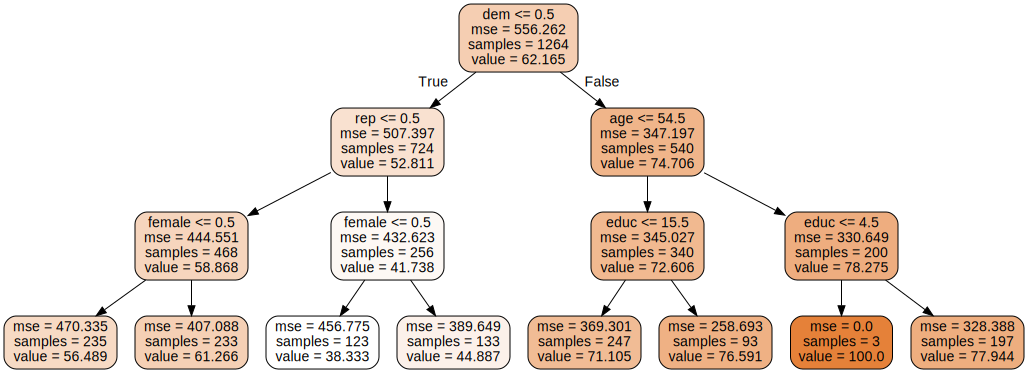

In [8]:
biden_tree2 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=3)
biden_tree2.fit(X_train, y_train)
y_pred = biden_tree.predict(X_test)
biden_tree2_viz = export_graphviz(biden_tree2, out_file=None, 
                                  rounded=True, filled=True, feature_names=variables)
graph2 = graphviz.Source(biden_tree2_viz)
graph2.render('biden_tree2_viz')
graph2

The sample average is 62.165. At the first step, the data is splitted by 'dem'. People who incline to the democrats (dem>0.5) tend to have higher biden scores (average = 74.7) compared those who do not incline to the domocrats (average = 52.8).

For those who incline to democrats, at the second step, the data is splitted by 'age'. People who are aged over 54.5 tend to have higher biden scores (average = 78.3) compared those who aged less than or equal to 54.5 (average = 72.6). At the third step, peope who aged less than or equal to 54.5 are splitted by 'educ'. People who have less than 15.5 years of education tend to have lower biden score compared with those who have longer education (average is 71.1 versus 76.6). Meanwhile, people who aged over 54.5 are splitted by 'educ'. People who have education of less than or equal to 4.5 years have an average biden score of 100 (with n = 3), while those with education over 4.5 years have an average biden score of 78.0.

For those who are not inclined to the democrats, at the second step, the data is splitted by 'rep'. The score is higher for those who are not inclined to the republicans (average = 58.9) compared with the democrats (average = 41.7). At the third step, people who are neither inclined to the democrats and the republicans are splitted by 'female'. Males have a lower average biden score (56.5) compared with females (61.3). People who are inclined to the republicans are also splitted by 'female'. Males have a lower average biden score (38.3) compared with females (44.9).

#### (c) Use the bagging approach to estimate a tree to create a model for predicting biden. What test MSE do you obtain? Obtain variable importance measures and interpret the results.

In [9]:
biden_tree3 = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                              max_samples=100, bootstrap=True, oob_score=True, random_state=15)
biden_tree3.fit(X,y)
biden_tree3.score(X,y)
y_pred3 = biden_tree3.oob_prediction_
MSE3 = mean_squared_error(y, y_pred3)
print('MSE=', MSE3)

MSE= 406.000558395


In [10]:
#Define the function to extract variable importance
def vimportance(esttree, X, features):
    importances = np.mean([tree.feature_importances_ for tree in esttree.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    # Print the feature ranking
    print("Feature ranking:")
    
    for f in range(X.shape[1]):
        print(str(f+1), ". ", features[f], ": ",str(importances[indices[f]]))
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), features)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [11]:
#Define the function to extract variable importance
def vimportancefix(esttree, X, features):
    '''
    This function is a revision of the scripts posted on:
    https://github.com/UC-MACSS/persp-model_W18/issues/228
    I have some doubts about the mapping (from indices to labels).
    I think the indices are sorted so that we cannot use the original sequence to compute the values.
    '''
    importances = np.mean([tree.feature_importances_ for tree in esttree.estimators_], axis=0)
    indices = np.argsort(importances)[::-1] #The index is sorted
    print("Feature ranking:")
    #So that we should generate a feature labels based on this sorting 
    newfeatures = [features[indices[f]] for f in range(len(features))]
    for f in range(X.shape[1]):
        print(str(f+1), ". ", newfeatures[f], ": ",str(importances[indices[f]]))
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), newfeatures)
    plt.xlim([-1, X.shape[1]])
    plt.show()

### The function to get variable importance - Original Version

Feature ranking:
1 .  female :  0.442912703961
2 .  age :  0.200576259716
3 .  educ :  0.190323544392
4 .  dem :  0.106028225513
5 .  rep :  0.060159266419


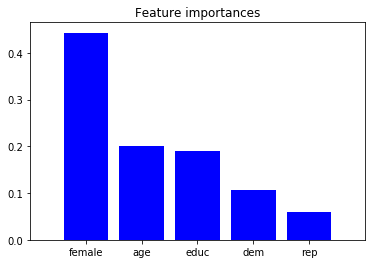

In [12]:
vimportance(biden_tree3, X, variables)

### Interpretation based on the original function

Based on our bagging estimate (with MSE=406.00), `female` appears to have the greatest importance in the model, followed by `age` and `dem`.

### The function to get variable importance - The Other Version

Feature ranking:
1 .  age :  0.442912703961
2 .  educ :  0.200576259716
3 .  dem :  0.190323544392
4 .  rep :  0.106028225513
5 .  female :  0.060159266419


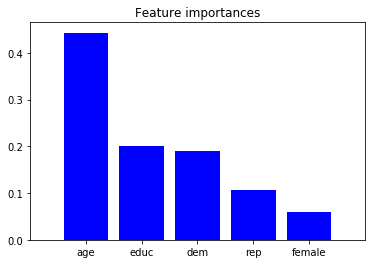

In [13]:
vimportancefix(biden_tree3, X, variables)

### Interpretation based on the other function

Based on our bagging estimate (with MSE=406.00), using the other function to get variable importance, `age` appears to have the greatest importance in the model, followed by `educ` and `dem`.

#### (d) Use the random forest approach to estimate a tree to create a model for predicting biden. Do this for $m=1, m=2$, and $m=3$ (the number of variables). What test MSE do you obtain in each case? Obtain variable importance measures and interpret the results. Describe the effect of $m$, the number of variables considered at each split, on the error rate obtained.

### d1) The function to get variable importance - Original Version

With m = 1, MSE = 532.8750579722736
Feature ranking:
1 .  female :  0.512175098628
2 .  age :  0.192432071629
3 .  educ :  0.150180547154
4 .  dem :  0.123879218183
5 .  rep :  0.0213330644052


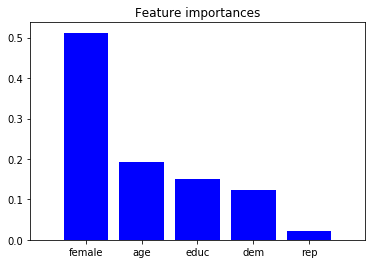


With m = 2, MSE = 538.192542935064
Feature ranking:
1 .  female :  0.50758431124
2 .  age :  0.191943514043
3 .  educ :  0.151423695616
4 .  dem :  0.127943907267
5 .  rep :  0.021104571834


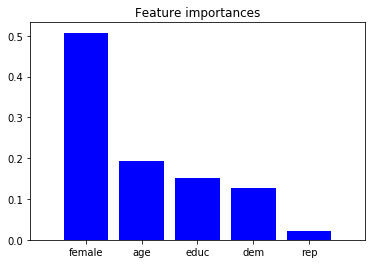


With m = 3, MSE = 535.7619627008756
Feature ranking:
1 .  female :  0.484652036367
2 .  age :  0.199165322239
3 .  educ :  0.165089462362
4 .  dem :  0.123722379345
5 .  rep :  0.0273707996866


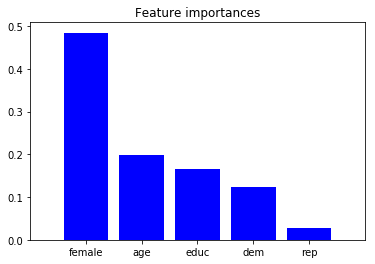

In [14]:
for i in range(3):
    biden_tree4 = RandomForestRegressor(n_estimators=53, max_features=i+1, bootstrap=True,
                                        oob_score=True, random_state=15)
    biden_tree4.fit(X, y)
    biden_tree4.score(X, y)
    y_pred4 = biden_tree4.oob_prediction_
    MSE4 = mean_squared_error(y, y_pred4)
    print('With m = {}, MSE = {}'.format(i+1, MSE4))
    vimportance(biden_tree4, X, variables)
    print('')

## Interpretation

With the updated variable importance function, we get the following:

The case m=1 produceds the smallest MSE among the three cases. Generally, the MSE should be lower if we input more of the predictors. However, in this case we may see *m=2* has the biggest MSE, though not a big difference from the case *m=1* and *m=3*. This fluctuating result suggests the importance of some variables are not that robust (some variables may be important in one case but not important in the other). Also, I guess we add or modify some arguments (e.g. n_estimator) so that we can get a robust result. 

### Variable Importance (with the original function)
Among all cases, `female` has the greatest importance in this model, followed by `age` and `educ`. Notice in all cases age has a relative large effect compared with the other features.

### d2) The function to get variable importance - The Other Version

With m = 1, MSE = 532.8750579722736
Feature ranking:
1 .  age :  0.512175098628
2 .  dem :  0.192432071629
3 .  educ :  0.150180547154
4 .  rep :  0.123879218183
5 .  female :  0.0213330644052


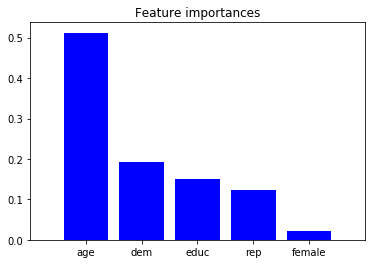


With m = 2, MSE = 538.192542935064
Feature ranking:
1 .  age :  0.50758431124
2 .  dem :  0.191943514043
3 .  educ :  0.151423695616
4 .  rep :  0.127943907267
5 .  female :  0.021104571834


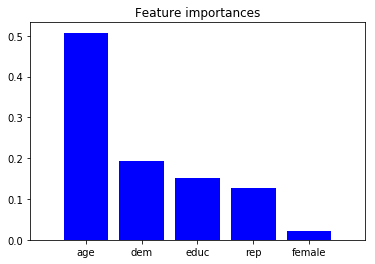


With m = 3, MSE = 535.7619627008756
Feature ranking:
1 .  age :  0.484652036367
2 .  dem :  0.199165322239
3 .  educ :  0.165089462362
4 .  rep :  0.123722379345
5 .  female :  0.0273707996866


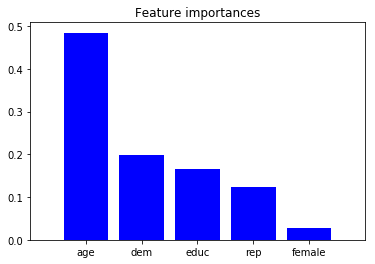

In [15]:
#Use defeault settings in the class notebook
for i in range(3):
    biden_tree4 = RandomForestRegressor(n_estimators=53, max_features=i+1, bootstrap=True,
                                        oob_score=True, random_state=15)
    biden_tree4.fit(X, y)
    biden_tree4.score(X, y)
    y_pred4 = biden_tree4.oob_prediction_
    MSE4 = mean_squared_error(y, y_pred4)
    print('With m = {}, MSE = {}'.format(i+1, MSE4))
    vimportancefix(biden_tree4, X, variables)
    print('')

## Interpretation

With the updated variable importance function, we get the following:

The case m=1 produceds the smallest MSE among the three cases. Generally, the MSE should be lower if we input more of the predictors. However, in this case we may see *m=2* has the biggest MSE, though not a big difference from the case *m=1* and *m=3*. This fluctuating result suggests the importance of some variables are not that robust (some variables may be important in one case but not important in the other). Also, I guess we add or modify some arguments (e.g. n_estimator) so that we can get a robust result. 

### Variable Importance (with the other function)
Among all cases, `age` has the greatest importance in this model, followed by `dem` and `educ`. Notice in all cases age has a relative large effect compared with the other features.